In [106]:
import pandas as pd
from openpyxl import load_workbook
import lagrangian_case as lc
import numpy as np
import matplotlib.pyplot as plt
import os
import utils
import random
import met_utils as mu
import xarray as xr
from scipy import stats
old_settings = np.seterr(invalid='ignore')  #seterr to known value
import warnings
warnings.simplefilter("ignore")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
combined_cases = {}
for key, case in lc.all_cases.items():
#     if key not in [6, 10]:
#         continue
    print(key)
    TLC = lc.TrajectoryCase(case['TLC_name'])
    TLC.add_traj_data()
    ALC = lc.AircraftCase(case['ALC_name'])
    ALC.add_ERA_data()
    ALC.add_precip_data()
    CLC = lc.CombinedCase(ALC, TLC, number=key)
    combined_cases[key] = CLC
#     CLC.plot(save=True)
    

1
adding ERA ens w_vert
adding ERA ens w_vert
adding ERA ens w_vert
2
adding ERA ens w_vert
adding ERA ens w_vert
3
adding ERA ens w_vert
adding ERA ens w_vert
adding ERA ens w_vert
adding ERA ens w_vert
4
adding ERA ens w_vert
adding ERA ens w_vert
5
adding ERA ens w_vert
adding ERA ens w_vert
adding ERA ens w_vert
adding ERA ens w_vert
adding ERA ens w_vert
6
adding ERA ens w_vert
adding ERA ens w_vert
adding ERA ens w_vert
adding ERA ens w_vert
adding ERA ens w_vert
7
adding ERA ens w_vert
adding ERA ens w_vert
adding ERA ens w_vert
8
adding ERA ens w_vert
adding ERA ens w_vert
9
adding ERA ens w_vert
adding ERA ens w_vert
10
adding ERA ens w_vert
adding ERA ens w_vert
11
adding ERA ens w_vert
adding ERA ens w_vert
adding ERA ens w_vert
adding ERA ens w_vert
12
adding ERA ens w_vert
adding ERA ens w_vert
13
adding ERA ens w_vert
14
adding ERA ens w_vert
adding ERA ens w_vert
15
adding ERA ens w_vert
adding ERA ens w_vert
16
adding ERA ens w_vert
adding ERA ens w_vert
17
adding ERA e

In [212]:
out_ret_vars = ['GOES_CF', 'EIS', 'LTS', 'delta_q', 'delta_T', 'CDP_Nd', 'CDP_Nd_p', 'zi', 'alpha_dec', 'UHSAS_Na',
                'UHSAS_Na_cld', 'median_prec',
                'mean_prec', 'O3', 'CO', 'SST', 'FT_RH', 'FT_q', 'FT_theta', 'zi_traj', 'lon_p']
fixed_vars = ['out_flight', 'out_seqs', 'ret_flight', 'ret_seqs', 'trajs', 'out_time', 'ret_time']
cols = fixed_vars[:]
[[cols.append('out_'+i), cols.append('ret_'+i), cols.append('diff_'+i)] for i in out_ret_vars]
lone_vars = ['subs', 'entr', 'entr_TLC', 'dzidt_ALC', 'subs_700', 'shf', 'lhf']
cols = cols + lone_vars


#to add: plane_CF, sfc_fluxes

df = pd.DataFrame(index=list(lc.all_cases.keys()) + ['lower_quartile', 'upper_quartile', 'mean'], columns=cols)

science rows:

casenum | CF (out,ret) | EIS (out,ret) | decoupling (out,ret) | zi (out,ret) | rain_rate (out,ret) | plane_Nd (out,ret) | Na (out,ret) | 




housekeeping rows:

out_seqs | ret_seqs| trajs | out_starttime | out_endtime | ret_starttime | ret_endtime | out_length | ret_length

In [213]:
for num, case in combined_cases.items():
#     print(num)
    df['out_flight'][num] = case.ALC.outbound_flight
    df['out_seqs'][num] = case.ALC.outbound_sequences
    df['ret_flight'][num] = case.ALC.return_flight
    df['ret_seqs'][num] = case.ALC.return_sequences
    df['trajs'][num] = case.TLC.trajectories
    df['out_time'][num] = case.ALC.outbound_flight_data.time.values[int(len(case.ALC.outbound_flight_data.time.values)/2)]
    df['ret_time'][num] = case.ALC.return_flight_data.time.values[int(len(case.ALC.return_flight_data.time.values)/2)]
    
    out_lat = case.ALC.outbound_flight_data.GGLAT.values[int(len(case.ALC.outbound_flight_data.GGLAT.values)/2)]
    out_lon = case.ALC.outbound_flight_data.GGLON.values[int(len(case.ALC.outbound_flight_data.GGLON.values)/2)]
    ret_lat = case.ALC.return_flight_data.GGLAT.values[int(len(case.ALC.return_flight_data.GGLAT.values)/2)]
    ret_lon = case.ALC.return_flight_data.GGLON.values[int(len(case.ALC.return_flight_data.GGLON.values)/2)]
    
    df['out_lon_p'][num] = utils.get_lon_prime(out_lat, out_lon)
    df['ret_lon_p'][num] = utils.get_lon_prime(ret_lat, ret_lon)
    
    
    df['out_GOES_CF'][num] = np.nanmean(case.ALC.outbound_Flight_Piece.GOES_data['2deg'].warm_low_cloud_fraction)
    df['ret_GOES_CF'][num] = np.nanmean(case.ALC.return_Flight_Piece.GOES_data['2deg'].warm_low_cloud_fraction)
    df['out_CDP_Nd'][num] = np.nanmedian(case.ALC.outbound_Flight_Piece.get_variable_by_leg(
        varname='CONCD_LWOI', legname='c', cloud_only=True).values)
    df['out_EIS'][num] = np.nanmean(case.ALC.outbound_Flight_Piece.ERA_data.ERA_EIS.values)
    df['ret_EIS'][num] = np.nanmean(case.ALC.return_Flight_Piece.ERA_data.ERA_EIS.values)
    df['out_SST'][num] = np.nanmean(case.ALC.outbound_Flight_Piece.ERA_data.ERA_sst.values)
    df['ret_SST'][num] = np.nanmean(case.ALC.return_Flight_Piece.ERA_data.ERA_sst.values)
    df['out_LTS'][num] = np.nanmean(case.ALC.outbound_Flight_Piece.ERA_data.ERA_LTS.values)
    df['ret_LTS'][num] = np.nanmean(case.ALC.return_Flight_Piece.ERA_data.ERA_LTS.values)
    df['ret_CDP_Nd'][num] = np.nanmedian(case.ALC.return_Flight_Piece.get_variable_by_leg(
        varname='CONCD_LWOI', legname='c', cloud_only=True).values)
    df['out_CDP_Nd_p'][num] = np.nanmedian(case.ALC.outbound_Flight_Piece.get_variable_by_leg(
        varname='CONCD_LWOI', legname='p', cloud_only=True).values)
    df['ret_CDP_Nd_p'][num] = np.nanmedian(case.ALC.return_Flight_Piece.get_variable_by_leg(
        varname='CONCD_LWOI', legname='p', cloud_only=True).values)

    out_profs = case.ALC.outbound_Flight_Piece.get_profiles()
    ret_profs = case.ALC.return_Flight_Piece.get_profiles()

    df['out_zi'][num] = np.nanmean([i['zi']['Heff']['z_bot'] for i in out_profs.values()])
    df['ret_zi'][num] = np.nanmean([i['zi']['Heff']['z_bot'] for i in ret_profs.values()])
    df['out_alpha_dec'][num] = np.nanmean([i['dec']['alpha_qt'] for i in out_profs.values()])
    df['ret_alpha_dec'][num] = np.nanmean([i['dec']['alpha_qt'] for i in ret_profs.values()])
    
    df['out_delta_T'][num] = np.nanmean([i['dec']['d_t_inv'] for i in out_profs.values()])
    df['ret_delta_T'][num] = np.nanmean([i['dec']['d_t_inv'] for i in ret_profs.values()])

    df['out_delta_q'][num] = np.nanmean([i['dec']['d_q_inv'] for i in out_profs.values()])
    df['ret_delta_q'][num] = np.nanmean([i['dec']['d_q_inv'] for i in ret_profs.values()])
    
    
    
    
    df['out_UHSAS_Na'][num] = np.nanmedian(case.ALC.outbound_Flight_Piece.get_variable_by_leg(
        varname='CONCU100_RWOOU', legname='b', cloud_only=True, flip_cloud_mask=True).values)
    df['ret_UHSAS_Na'][num] = np.nanmedian(case.ALC.return_Flight_Piece.get_variable_by_leg(
        varname='CONCU100_RWOOU', legname='b', cloud_only=True, flip_cloud_mask=True).values)
    
    df['out_UHSAS_Na_cld'][num] = np.nanmedian(case.ALC.outbound_Flight_Piece.get_variable_by_leg(
        varname='CONCU100_RWOOU', legname='c', cloud_only=True, flip_cloud_mask=True).values)
    df['ret_UHSAS_Na_cld'][num] = np.nanmedian(case.ALC.return_Flight_Piece.get_variable_by_leg(
        varname='CONCU100_RWOOU', legname='c', cloud_only=True, flip_cloud_mask=True).values)
    
    df['out_mean_prec'][num] = np.nanmean(case.ALC.outbound_Flight_Piece.get_max_precip_by_leg(
        legname='b').values*3.6)
    df['ret_mean_prec'][num] = np.nanmean(case.ALC.return_Flight_Piece.get_max_precip_by_leg(
        legname='b').values*3.6)
    
    df['out_median_prec'][num] = np.nanmedian(case.ALC.outbound_Flight_Piece.get_max_precip_by_leg(
        legname='b').values*3.6)
    df['ret_median_prec'][num] = np.nanmedian(case.ALC.return_Flight_Piece.get_max_precip_by_leg(
        legname='b').values*3.6)
    
    df['out_CO'][num] = np.nanmedian(case.ALC.outbound_Flight_Piece.get_variable_by_leg(
        varname='CO', legname='b', cloud_only=False).values)
    df['ret_CO'][num] = np.nanmedian(case.ALC.return_Flight_Piece.get_variable_by_leg(
        varname='CO', legname='b', cloud_only=False).values)
    
    df['out_O3'][num] = np.nanmedian(case.ALC.outbound_Flight_Piece.get_variable_by_leg(
        varname='O3', legname='b', cloud_only=False).values)
    df['ret_O3'][num] = np.nanmedian(case.ALC.return_Flight_Piece.get_variable_by_leg(
        varname='O3', legname='b', cloud_only=False).values)
    df['out_FT_RH'][num] = np.nanmean(case.ALC.outbound_Flight_Piece.ERA_data.ERA_r.sel(level=700).values)
    df['ret_FT_RH'][num] = np.nanmean(case.ALC.return_Flight_Piece.ERA_data.ERA_r.sel(level=700).values)
    
    df['out_FT_q'][num] = np.nanmean(case.ALC.outbound_Flight_Piece.ERA_data.ERA_q.sel(level=700).values)*1000
    df['ret_FT_q'][num] = np.nanmean(case.ALC.return_Flight_Piece.ERA_data.ERA_q.sel(level=700).values)*1000
    
    
    df['out_FT_theta'][num] = np.nanmean(mu.theta_from_p_T(700, case.ALC.outbound_Flight_Piece.ERA_data.ERA_t.sel(level=700).values))
    df['ret_FT_theta'][num] = np.nanmean(mu.theta_from_p_T(700, case.ALC.return_Flight_Piece.ERA_data.ERA_t.sel(level=700).values))
    

    #doing subsidence and entrainment
    subs_vals = []
    for k,v in case.TLC.get_from_inv('ERA_w_vert').items():
        index = np.logical_and(case.TLC.traj_data[k].time > df['out_time'][num], case.TLC.traj_data[k].time < df['ret_time'][num])
        subs_vals.append(np.nanmean(v[index]))
    df['subs'][num] = np.nanmean(subs_vals)*1000
    
    subs_700_vals = []
    shf_vals = []
    lhf_vals = []

    for k,v in case.TLC.traj_data.items():
        subs_700_vals.append(np.nanmean(v['ERA_w_vert'].sel(level=700, time=slice(df['out_time'][num], df['ret_time'][num]))))
        shf_vals.append(-np.nanmean(v['ERA_ishf'].sel(time=slice(df['out_time'][num], df['ret_time'][num]))))
        lhf_vals.append(-np.nanmean(v['ERA_ie'].sel(time=slice(df['out_time'][num], df['ret_time'][num])))*2.4625*1e6)
    
    df['subs_700'][num] = np.nanmean(subs_700_vals)*1000
    df['shf'][num] = np.nanmean(shf_vals)
    df['lhf'][num] = np.nanmean(lhf_vals)

    
    
    dzdt_ALC = (df['ret_zi'][num] - df['out_zi'][num])/(utils.as_datetime(df['ret_time'][num]) - utils.as_datetime(df['out_time'][num])).total_seconds()*1000
    df['dzidt_ALC'][num] = dzdt_ALC
    df['entr'][num] = dzdt_ALC - df['subs'][num]
    

    zi_init_vals = []
    zi_final_vals = []
    for k,v in case.TLC.get_from_inv('z_i').items():
            zi_init_vals.append(v[np.argmin(np.abs(case.TLC.traj_data[k].time.values - df['out_time'][num]))])
            zi_final_vals.append(v[np.argmin(np.abs(case.TLC.traj_data[k].time.values - df['ret_time'][num]))])

    df['out_zi_traj'][num] = np.nanmean(zi_init_vals)
    df['ret_zi_traj'][num] = np.nanmean(zi_final_vals)
            
            
    dzdt_TLC = (df['ret_zi_traj'][num] - df['out_zi_traj'][num])/(utils.as_datetime(df['ret_time'][num]) - utils.as_datetime(df['out_time'][num])).total_seconds()*1000
    df['entr_TLC'][num] = dzdt_TLC - df['subs'][num]
    


    ['plane_CF']
    
    
    for v in out_ret_vars:
        df['diff_'+v][num] = df['ret_'+v][num] - df['out_'+v][num]

for v in [i for i in df.keys() if i not in fixed_vars]:
    vals = df[v][0:18].astype('float')
    df[v]['mean'] = np.nanmean(vals)
    df[v]['lower_quartile'] = np.nanpercentile(vals, 10)
    df[v]['upper_quartile'] = np.nanpercentile(vals, 90)
        
print("done")

(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
(73,)
done


In [29]:
for n in [6, 10]:
    print('\nworking on {}'.format(n))
    for v in [i for i in df.keys() if i not in fixed_vars]:
        if df[v][n] > df[v]['upper_quartile']:
            print(v + ' very big')
        elif df[v][n] < df[v]['lower_quartile']:
            print(v + ' very small')


working on 6
out_delta_q very big
ret_delta_T very small
out_CDP_Nd very small
ret_CDP_Nd very small
ret_CDP_Nd_p very small
ret_zi very big
diff_zi very big
ret_UHSAS_Na very small
out_UHSAS_Na_cld very small
ret_UHSAS_Na_cld very small
ret_O3 very small
diff_zi_traj very big
entr very big
dzidt_ALC very big

working on 10
out_GOES_CF very big
out_EIS very big
diff_EIS very small
out_LTS very big
diff_LTS very small
ret_delta_q very big
out_CDP_Nd very big
diff_CDP_Nd very small
out_CDP_Nd_p very big
diff_CDP_Nd_p very small
ret_UHSAS_Na very big
out_UHSAS_Na_cld very big
diff_UHSAS_Na_cld very small
ret_O3 very big
out_CO very big
ret_CO very big
out_FT_RH very small
ret_FT_RH very big
diff_FT_RH very big
out_FT_q very small
ret_FT_q very big
diff_FT_q very big
out_FT_theta very big
diff_FT_theta very small


In [152]:
miss_vars = [pref+suff for suff in ['CDP_Nd_p', 'UHSAS_Na_cld', 'FT_theta', 'zi_traj'] for pref in ['out_', 'ret_', 'diff_']]
df.T[[6, 10, 'mean']].drop(fixed_vars+miss_vars)
# df[['out_O3', 'ret_O3']]
# np.nanmean(df['diff_mean_prec'])*3.6
# df.T




,6,10,mean
out_GOES_CF,0.951868,1,0.84575
ret_GOES_CF,0.390778,0.775851,0.531341
diff_GOES_CF,-0.56109,-0.224149,-0.314409
out_EIS,5.67719,8.4881,6.45751
ret_EIS,2.97035,3.62701,4.27248
diff_EIS,-2.70684,-4.86108,-2.18502
out_LTS,19.9106,21.6725,19.3384
ret_LTS,16.0166,16.4312,17.149
diff_LTS,-3.89401,-5.24136,-2.1894
out_delta_q,-1.85662,-2.41085,-4.47374


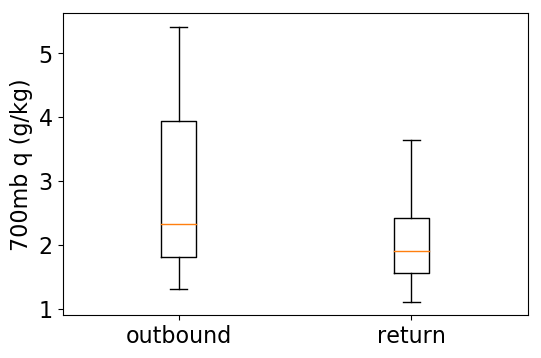

In [57]:
fig, ax = plt.subplots()
ax.boxplot([df.T[np.arange(1,19)].T.out_FT_q.values, df.T[np.arange(1,19)].T.ret_FT_q.values], labels=['outbound', 'return'])
ax.set_ylabel('700mb q (g/kg)')
fig.savefig(os.path.join(utils.plot_dir, "700mb_q_boxwhisker.png"), dpi=600, bbox_inches='tight')

In [29]:
path = '/home/disk/eos4/jkcm/Data/CSET/Lagrangian_cases_table.xlsx'

book = load_workbook(path)
writer = pd.ExcelWriter(path, engine = 'openpyxl')
writer.book = book
df.T.to_excel(writer,'raw')
writer.save()

In [ ]:
book = load_workbook('/home/disk/eos4/jkcm/Data/CSET/Lagrangian_cases_table.xlsx')
writer = pd.ExcelWriter('/home/disk/eos4/jkcm/Data/CSET/Lagrangian_cases_table.xlsx', engine='openpyxl') 
writer.book = book
writer.sheets = dict((ws.title, ws) for ws in book.worksheets)
df.to_excel(writer, "Dump")

writer.save()

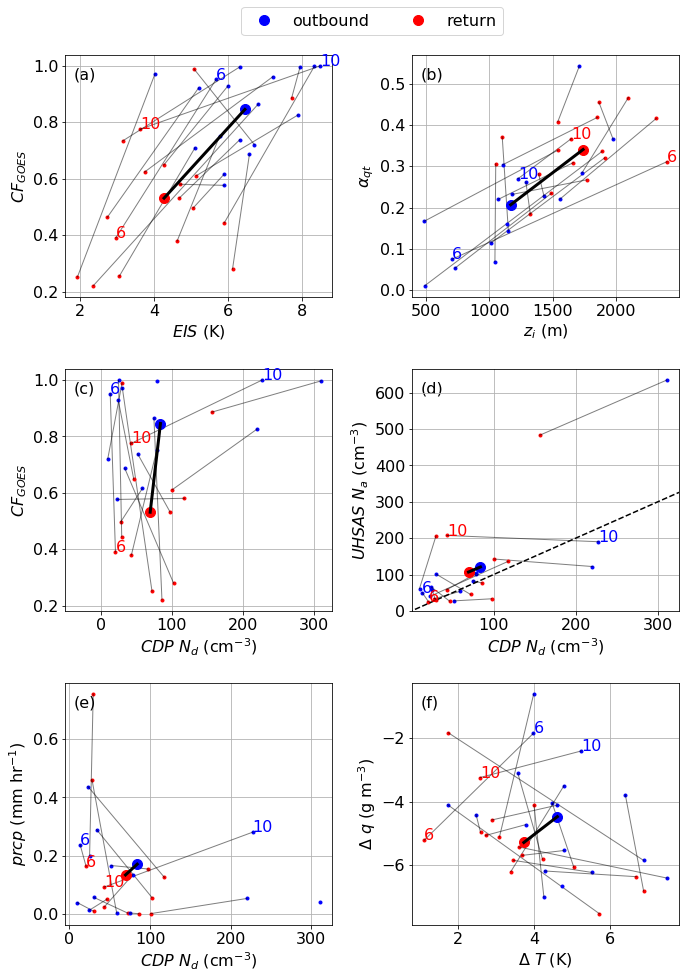

In [155]:
def plot_from_bigtable(df, var_a, var_b, a_name=None, b_name=None, title=None, ax=None, one2one=False):
    df = df.drop(['upper_quartile', 'lower_quartile', 'mean'], axis=0)
    if ax is None:
        fig, ax = plt.subplots()
    if a_name is None:
        a_name = var_a
    if b_name is None:
        b_name = var_b
    if title is None:
        title = var_a + " vs " + var_b
    for index, row in df.iterrows():
        if np.isnan(row['out_'+var_b]) or np.isnan(row['out_'+var_a]):
            continue
        ax.plot(row['out_'+var_b], row['out_'+var_a], '.', c='b')
        if index in [6, 10]:
            ax.annotate(s=str(index), xy=(row['out_'+var_b], row['out_'+var_a]), fontsize=16, color='b')
            ax.annotate(s=str(index), xy=(row['ret_'+var_b], row['ret_'+var_a]), fontsize=16, color='r')
        ax.plot(row['ret_'+var_b], row['ret_'+var_a], '.', c='r')
        ax.plot([row['out_'+var_b], row['ret_'+var_b]], [row['out_'+var_a], row['ret_'+var_a]], c='k', lw=1, alpha=0.5)
    ax.plot(np.nanmean(df['out_'+var_b]), np.nanmean(df['out_'+var_a]), '.', c='b', ms=20, label='outbound')
    ax.plot(np.nanmean(df['ret_'+var_b]), np.nanmean(df['ret_'+var_a]), '.', c='r', ms=20, label='return')
    ax.plot([np.nanmean(df['out_'+var_b]), np.nanmean(df['ret_'+var_b])], [np.nanmean(df['out_'+var_a]), np.nanmean(df['ret_'+var_a])], 
            c='k', lw=3)
    if one2one:
        xlims, ylims = list(ax.get_xlim()), list(ax.get_ylim())
        xlims[0] = max(xlims[0], 1)
        ylims[0] = max(ylims[0], 1)
        min_v = max(ax.get_xlim()[0], ax.get_ylim()[0])
        max_v = min(ax.get_xlim()[1], ax.get_ylim()[1])
        ax.plot([min_v, max_v], [min_v, max_v], 'k--', label='1-1 line')
        ax.set_ylim(ylims)
        ax.set_xlim(xlims)

    #ax.legend()
    
#     if var_a in ["CDP_Nd", "UHSAS_Na"]:
#         ax.set_yscale('log')
#     if var_b in ["CDP_Nd", "UHSAS_Na"]:
#         ax.set_xscale('log')
    
    
    ax.set_xlabel(b_name)
    ax.set_ylabel(a_name)
#     ax.set_title(title)
    ax.annotate('({})'.format(title[0]), xy=(0.03, 0.9), xycoords='axes fraction', backgroundcolor='white', fontsize=16, zorder=0)
    ax.grid(True)
    return ax
    
    
fig, [[ax1, ax2], [ax3,ax4], [ax5, ax6]] = plt.subplots(nrows=3, ncols=2, figsize=(11,16))
    
plot_from_bigtable(df, var_a='GOES_CF', var_b='EIS', a_name="$CF_{GOES}$", b_name="$EIS$ (K)", title="a) Cloud Fraction vs EIS", ax=ax1)
plot_from_bigtable(df, var_a='alpha_dec', var_b='zi', a_name=r'$\alpha_{qt}$', b_name=r'$z_i$ (m)', title='b) Decoupling vs Depth', ax=ax2)
plot_from_bigtable(df, var_a='GOES_CF', var_b='CDP_Nd', a_name="$CF_{GOES}$", b_name=r"$CDP\ N_d$ (cm$^{-3}$)", title=r'c) Cloud Fraction vs $N_d$', ax=ax3)
plot_from_bigtable(df, var_a='UHSAS_Na', var_b='CDP_Nd', a_name="$UHSAS\ N_a$ (cm$^{-3}$)", b_name="$CDP\ N_d$ (cm$^{-3}$)", title=r'd) $N_a$ vs $N_d$', ax=ax4, one2one=True)
# plot_from_bigtable(df, var_a='zi', var_b='EIS', a_name=r"$z_i$ (m)", b_name="$EIS$ (K)", title="e) Depth vs EIS", ax=ax5)
plot_from_bigtable(df, var_a='mean_prec', var_b='CDP_Nd', a_name=r"$prcp$ (mm hr$^{-1}$)", b_name=r"$CDP\ N_d$ (cm$^{-3}$)", title="e) Depth vs EIS", ax=ax5)

plot_from_bigtable(df, var_a='delta_q', var_b='delta_T', a_name="$\Delta\ q$ (g m$^{-3}$)", b_name=r"$\Delta\ T$ (K)", title=r"f) $\Delta$ q vs $\Delta$ T", ax=ax6)

ax3.set_xlim(-50, ax3.get_xlim()[1])
all_cf = np.hstack([df['out_GOES_CF'].values,df['ret_GOES_CF'].values])
all_lts = np.hstack([df['out_LTS'].values,df['ret_LTS'].values])
all_eis = np.hstack([df['out_EIS'].values,df['ret_EIS'].values])

# slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(all_eis.tolist(), all_cf.tolist())

# xs = np.linspace(np.nanmin(all_eis), np.nanmax(all_eis), 50)
# ys = intercept2 + slope2*xs
# ax1.plot(xs, ys, 'k--', label='naive fit')
# h, l = ax1.get_legend_handles_labels()
# ax1.legend(h[2:], l[2:])
fig.subplots_adjust(hspace=0.3, wspace=0.3)
ax2.legend(loc='lower center', ncol=2, bbox_to_anchor=(-0.15, 1.05));

fig.savefig(os.path.join(utils.plot_dir, "4_changes_in_things.png"), dpi=600, bbox_inches='tight')

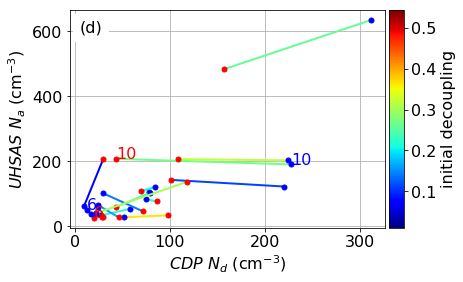

In [175]:
import matplotlib

cmap = matplotlib.cm.get_cmap('jet')


import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots()
var_a='UHSAS_Na'
var_b='CDP_Nd'
a_name="$UHSAS\ N_a$ (cm$^{-3}$)"
b_name="$CDP\ N_d$ (cm$^{-3}$)"
title=r'd) $N_a$ vs $N_d$'
one2one=True

dec_min = min((df.ret_alpha_dec + df.out_alpha_dec)/2)
dec_max = max((df.ret_alpha_dec + df.out_alpha_dec)/2)
dec_min, dec_max = min(df.out_alpha_dec), max(df.out_alpha_dec)
norm = mpl.colors.Normalize(vmin=dec_min,vmax=dec_max)
x1, x2 = [], []
for index, row in df.iterrows():
    mean_dec = (row['out_alpha_dec'] + row['ret_alpha_dec'])/2
    mean_dec = row['out_alpha_dec']
    if np.isnan(row['out_'+var_b]) or np.isnan(row['out_'+var_a]):
        continue
    x2.append(mean_dec)

    if index in [6, 10]:
        ax.annotate(s=str(index), xy=(row['out_'+var_b], row['out_'+var_a]), fontsize=16, color='b')
        ax.annotate(s=str(index), xy=(row['ret_'+var_b], row['ret_'+var_a]), fontsize=16, color='r')
    color= cmap(norm(mean_dec))
    ax.plot([row['out_'+var_b], row['ret_'+var_b]], [row['out_'+var_a], row['ret_'+var_a]], c=color, lw=2, alpha=1)
    ax.plot(row['out_'+var_b], row['out_'+var_a], '.', c='b', ms=10)
    ax.plot(row['ret_'+var_b], row['ret_'+var_a], '.', c='r', ms=10)
    slope = (row['ret_'+var_a] - row['out_'+var_a])*1.0/(row['ret_'+var_b] - row['out_'+var_b])
    x1.append(slope)
    
ax.set_xlabel(b_name)
ax.set_ylabel(a_name)
#     ax.set_title(title)
ax.annotate('({})'.format(title[0]), xy=(0.03, 0.9), xycoords='axes fraction', backgroundcolor='white', fontsize=16)
ax.grid(True)

divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
cb1 = mpl.colorbar.ColorbarBase(ax_cb, cmap=mpl.cm.jet, orientation='vertical', norm=norm)
plt.gcf().add_axes(ax_cb)
cb1.set_label('initial decoupling')
# ax_cb.set_yticklabels([np.around(i/2, 1) for i in ax_cb.get_yticks()])
# ax.set_yscale('log')
# ax.set_xscale('log')
plt.show()
fig.savefig(os.path.join(utils.plot_dir, "rev_decoupling vs na-nd.png"), dpi=600, bbox_inches='tight')

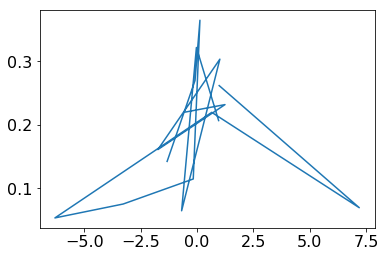

In [170]:
plt.plot(x1, x2)

In [167]:
x1

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [86]:
print('workin')

workin


In [ ]:
ax_cb.get_yticks()

In [19]:
eis_slope

1                  48.3027
2                 -16.4252
3                  88.9771
4                  14.3242
5                  22.7916
6                  20.7286
7                  7.82536
8                  9.74814
9                  12.6466
10                 4.61109
11                 34.3377
12                 22.2523
13                 8.29059
14                 18.5852
15                 14.4403
16                 32.3768
17                 16.1736
18               -0.330956
lower_quartile     15.5568
upper_quartile     10.6542
mean               14.3893
dtype: object

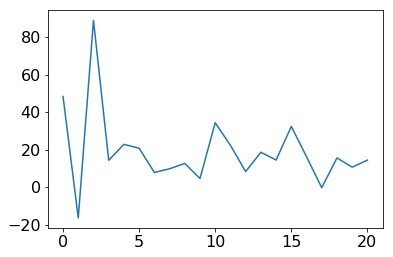

In [20]:
plt.plot(eis_slope.values)

In [27]:
eis_slope.values.astype(float)

array([ 48.30269718, -16.42521032,  88.9771448 ,  14.32417302,
        22.79158096,  20.7286178 ,   7.82535746,   9.74814058,
        12.64663264,   4.61108748,  34.33774292,  22.25230156,
         8.29059012,  18.58523395,  14.44029268,  32.37684685,
        16.17360682,  -0.33095597,  15.55684535,  10.65423476,
        14.38927574])

In [56]:
# print("naive slope of lts {:0.1f}%/K".format(slope*100))
# print("naive slope of eis {:0.1f}%/K".format(slope2*100))
lts_slope = df['diff_GOES_CF'][:18]*100/df['diff_LTS'][:18]
eis_slope = df['diff_GOES_CF'][:18]*100/df['diff_EIS'][:18]
print("mean slope of lts: {:0.1f}%/K".format(np.nanmean(lts_slope)))
print("std dev slope of lts: {:0.1f}%/K".format(np.nanstd(lts_slope[lts_slope<100])))

print("mean slope of eis: {:0.1f}%/K".format(np.nanmean(eis_slope[eis_slope<70])))
print("median slope of eis: {:0.1f}%/K".format(np.nanmedian(eis_slope.values.astype(float))))

print("std dev slope of eis: {:0.1f}%/K".format(np.nanstd(eis_slope)))

lts_slope_2 = 100*(np.nanmean(df['out_GOES_CF'][:18])-np.nanmean(df['ret_GOES_CF'][:18]))/(np.nanmean(df['out_LTS'][:18])-np.nanmean(df['ret_LTS'][:18]))
eis_slope_2 = 100*(np.nanmean(df['out_GOES_CF'][:18])-np.nanmean(df['ret_GOES_CF'][:18]))/(np.nanmean(df['out_EIS'][:18])-np.nanmean(df['ret_EIS'][:18]))
print("slope of 'mean lts': {:0.1f}%/K\nslope of 'mean eis': {:0.1f}%/K".format(lts_slope_2, eis_slope_2))
dec_depth_slope = 1000*(np.nanmean(df['out_alpha_dec'][:18])-np.nanmean(df['ret_alpha_dec'][:18]))/(np.nanmean(df['out_zi'][:18])-np.nanmean(df['ret_zi'][:18]))
dec_depth_slope_2 = (1000*df['diff_alpha_dec'][:18]/df['diff_zi'][:18]).values.astype(float)
dec_depth_slope_2 = dec_depth_slope_2[np.abs(dec_depth_slope_2)<1]
print("slope of 'mean dec': {:0.2f}/km".format(dec_depth_slope))
print("mean slope of dec/depth: {:0.2f}/km".format(np.nanmean(dec_depth_slope_2)))
print("s.e.m. slope of dec/depth: {:0.2f}/km".format(np.nanstd(dec_depth_slope_2)/np.sqrt(len(dec_depth_slope_2))))

print("median slope of dec/depth: {:0.2f}/km".format(np.nanmedian(dec_depth_slope_2)))
print("std dev slope of dec/depth: {:0.2f}/km".format(np.nanstd(dec_depth_slope_2)))

mean slope of lts: 34.1%/K
std dev slope of lts: 24.0%/K
mean slope of eis: 15.9%/K
median slope of eis: 15.3%/K
std dev slope of eis: 21.6%/K
slope of 'mean lts': 14.4%/K
slope of 'mean eis': 14.4%/K
slope of 'mean dec': 0.23/km
mean slope of dec/depth: 0.18/km
s.e.m. slope of dec/depth: 0.09/km
median slope of dec/depth: 0.23/km
std dev slope of dec/depth: 0.34/km


In [54]:
eis_slope

1      48.3027
2     -16.4252
3      88.9771
4      14.3242
5      22.7916
6      20.7286
7      7.82536
8      9.74814
9      12.6466
10     4.61109
11     34.3377
12     22.2523
13     8.29059
14     18.5852
15     14.4403
16     32.3768
17     16.1736
18   -0.330956
dtype: object

In [63]:
x

SyntaxError: can't use starred expression here (<ipython-input-63-c89c297cb2ee>, line 1)

In [74]:
x1

array([0.26182076, 0.0693169 , 0.22881927, 0.21966465, 0.05323368,
       0.07515653, 0.11462935, 0.28394601, 0.36488798, 0.26987839,
       0.14232001, 0.54289049, 0.01107898, 0.16691655, 0.21996267,
       0.23188987, 0.16099826, 0.30353069])

In [73]:
np.delete(ax1, 2)

array([0.26182076, 0.0693169 , 0.21966465, 0.05323368, 0.07515653,
       0.11462935, 0.28394601, 0.36488798, 0.26987839, 0.14232001,
       0.54289049, 0.01107898, 0.16691655, 0.21996267, 0.23188987,
       0.16099826, 0.30353069])

In [148]:
x1, x2, x3, x4 = df['out_alpha_dec'][:18].values.astype(float), df['ret_alpha_dec'][:18].values.astype(float), \
                df['out_zi'][:18].values.astype(float), df['ret_zi'][:18].values.astype(float)
def fn(x1, x2, x3, x4): return 1000*(np.nanmean(x1)-np.nanmean(x2))/(np.nanmean(x3)-np.nanmean(x4))
list_o_vars = [x1, x2, x3, x4]
# def bootstrap_rando_fun(fn, list_o_vars):
# if True:
#     def resample(x, i):
#         return np.delete(x, i)
#     return_vals = []
#     i_arr=np.arange(len(list_o_vars[0]))
#     applied_vars = [list(map(lambda x: resample(x, i), list_o_vars)) for i in i_arr]
#     results = []
#     for i in range(100):
#         results.append(fn(*random.)
    
#     #     results = [fn(*var_list) for var_list in applied_vars]
#     results
# #     applied_vars = map(lambda x: resample(x, i), list_o_vars)
                       
def proper_bootstrap(fn, list_o_vars, samples=1000):
    results = []
    len_x = len(list_o_vars[0])
    for i in range(samples):
        idx = np.random.choice(len_x,len_x)
        ran_choices = list(zip(*np.array(list(zip(*list_o_vars)))[idx]))
        res = fn(*ran_choices)
        results.append(res)
    return results

results = proper_bootstrap(fn, list_o_vars)
print(np.nanmean(results))
print(np.nanstd(results))

0.24192838608171155
0.052154416399538224


In [147]:
x = np.arange(10)
y = np.arange(10)*10

[(0.2618207633495331,
  0.1839824616909027,
  1286.9397431376728,
  1322.0683483235216),
 (0.06931690126657486,
  0.30577898025512695,
  1042.9925940562507,
  1049.4532258239124),
 (0.22881926596164703,
  0.2818101942539215,
  1428.7356018061441,
  1386.8466641255452),
 (0.21966464817523956,
  0.41573458909988403,
  1552.4583976876934,
  2314.2813759668506),
 (0.05323368310928345,
  0.23433494567871094,
  728.1206858498751,
  1487.4934730596583),
 (0.07515653222799301,
  0.31102657318115234,
  707.1170572938111,
  2398.4948293641232),
 (0.1146293506026268,
  0.320254921913147,
  1014.3325874904306,
  1907.2537189160757),
 (0.2839460074901581,
  0.46639323234558105,
  1729.0142442064284,
  2094.8650073544627),
 (0.3648879826068878,
  0.4550481140613556,
  1974.9142865532299,
  1862.0857457624995),
 (0.2698783874511719,
  0.36681121587753296,
  1225.2462353907652,
  1645.0942309679422),
 (0.14232000708580017,
  0.37075456976890564,
  1149.1934088037838,
  1100.669287462012),
 (0.54289048

In [126]:
idx = np.random.choice(len(x),len(x))
np.array(list(zip(x,y)))[idx].tolist()

# np.raandom.choice(list(zip(x,y)), 4)

[[4, 40],
 [7, 70],
 [0, 0],
 [2, 20],
 [4, 40],
 [2, 20],
 [1, 10],
 [9, 90],
 [8, 80],
 [8, 80]]

In [113]:
np.random.choice(x, size=4)

array([5, 7, 0, 6])

In [93]:
list(applied_vars)

TypeError: 'map' object is not callable

In [81]:
x = map(lambda x : x*2, [1, 2, 3, 4]) #Output [2, 4, 6, 8]

In [83]:
list(x)

[2, 4, 6, 8]

In [16]:
all_nd = np.hstack([df['out_CDP_Nd'].values,df['ret_CDP_Nd'].values]).astype(float)
all_na = np.hstack([df['out_UHSAS_Na'].values,df['ret_UHSAS_Na'].values]).astype(float)
index = np.logical_and(~np.isnan(all_nd), ~np.isnan(all_na))
print(index)
slope, intercept, r_value, p_value, std_err = stats.linregress(all_nd[index].tolist(), all_na[index].tolist())
print(r_value)

[ True  True False  True  True  True  True False  True  True  True False
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True  True  True]
0.721026557496301


In [15]:
all_EIS = np.hstack([df['out_EIS'].values,df['ret_EIS'].values]).astype(float)
all_dt = np.hstack([df['out_delta_T'].values,df['ret_delta_T'].values]).astype(float)
index = np.logical_and(~np.isnan(all_EIS), ~np.isnan(all_dt))
print(index)
slope, intercept, r_value, p_value, std_err = stats.linregress(all_EIS[index].tolist(), all_dt[index].tolist())
print(r_value)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True]
0.4653240911482415


-0.011809212332311372 0.14485713600068859 -0.011581547608236464
0.5191997461902842
LinregressResult(slope=0.1278281053023361, intercept=0.04644079902225354, rvalue=0.3922347645031549, pvalue=0.14816633448182895, stderr=0.08314435269170838)


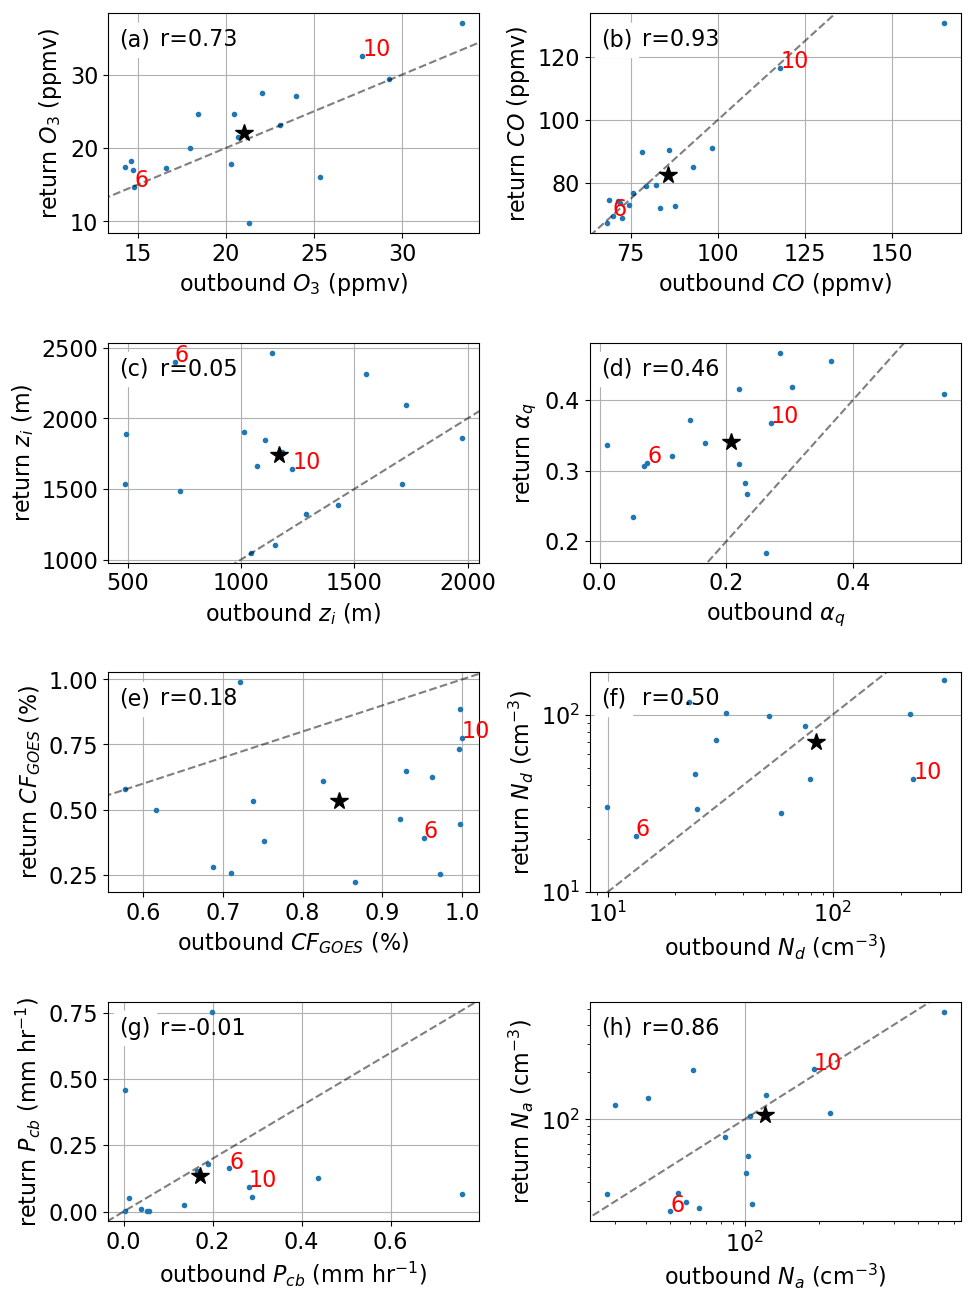

In [216]:
def plot_coherence(df, varname, label, units='', ax=None, pmeans=False):
    df = df.drop(['upper_quartile', 'lower_quartile', 'mean'], axis=0)
    if ax is None:
        fig, ax = plt.subplots()
    x_data = np.array(df['out_' + varname].values.astype(float))
    y_data = np.array(df['ret_' + varname].values.astype(float))
    ax.plot(x_data, y_data, '.')
    ax.plot(np.nanmean(x_data), np.nanmean(y_data), '*', ms=13, mfc='black', mec='black')
    if pmeans:
        print(np.nanmean(x_data), np.nanmean(y_data))
    if varname in ["CDP_Nd", "UHSAS_Na"]:
        ax.set_yscale('log')
        ax.set_xscale('log')
        
    
    
    for index, row in df.iterrows():
        if ~np.isnan(row['out_'+varname]) and  ~np.isnan(row['ret_'+varname]):
            if index in [6, 10]:
                ax.annotate(s=str(index), xy=(row['out_'+varname], row['ret_'+varname]), fontsize=16, color='red')

    
    
    end = ' ({})'.format(units) if units is not None else ""
    ax.set_xlabel('outbound ' + (label) + end)
    ax.set_ylabel('return ' + (label) + end)
    ax.grid(True)
    
    index = np.logical_and(~np.isnan(x_data), ~np.isnan(y_data))

    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data[index], y_data[index])
    if varname == 'mean_prec':
        print(slope, intercept, r_value)
    ylims=ax.get_ylim()
    xlims=ax.get_xlim()
    
    min_v = min(xlims[0], ylims[0])
    max_v = max(xlims[1], ylims[1])
    xs = np.linspace(min_v, max_v, 10)
    ys = slope*xs + intercept
#     ax.plot(xs,ys, label="r^2: {:0.3f}".format(r_value**2))
#     ax.plot(xs,ys, label="best fit: r: {:0.3f}".format(r_value))

    

    ax.plot([min_v, max_v], [min_v, max_v], '--k', alpha=0.5, label='1-1 line')
#     ax.legend()
    ax.annotate('r={:0.2f}'.format(r_value), xy=(0.14, 0.85), xycoords='axes fraction', backgroundcolor='None', fontsize=16)

    
#     min_p = min(ax.get_xlim()[0], ax.get_ylim()[0])
#     max_p = max(ax.get_xlim()[1], ax.get_ylim()[1])
    
    ax.set_ylim(ylims)
    ax.set_xlim(xlims)
    
#     rint("r-squared:", r_value**2)
#     r-squared: 0.08040226853902833
    
    
fig, [[ax1, ax2], [ax3,ax4], [ax5, ax6], [ax7, ax8]] = plt.subplots(nrows=4, ncols=2, figsize=(11,16))
   

plot_coherence(df, varname="O3", label='$O_3$', units="ppmv", ax=ax1)
plot_coherence(df, varname="CO", label='$CO$', units="ppmv", ax=ax2)
plot_coherence(df, varname="zi", label='$z_i$', units="m", ax=ax3)
plot_coherence(df, varname="alpha_dec", label=r'$\alpha_q$', units=None, ax=ax4)
plot_coherence(df, varname="GOES_CF", label='$CF_{GOES}$', units="%", ax=ax5)
plot_coherence(df, varname="CDP_Nd", label='$N_d$', units="cm$^{-3}$", ax=ax6)
plot_coherence(df, varname="mean_prec", label='$P_{cb}$', units="mm hr$^{-1}$", ax=ax7)
plot_coherence(df, varname="UHSAS_Na", label=r'$N_a$', units="cm$^{-3}$", ax=ax8)


ax6.set_yticks([10, 100])

fig.subplots_adjust(hspace=0.5, wspace=0.3)

for axi, l in zip([ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8], 'abcdefgh'):
    axi.annotate('({})'.format(l), xy=(0.03, 0.85), xycoords='axes fraction', backgroundcolor='white', fontsize=16)
""

fig.savefig(os.path.join(utils.plot_dir, "3_Lagrangian_coherence.png"), dpi=600, bbox_inches='tight')





Na_out = np.array(df['out_UHSAS_Na'].values.astype(float))
Na_ret = np.array(df['ret_UHSAS_Na'].values.astype(float))
index = np.logical_and(np.logical_and(~np.isnan(Na_out), ~np.isnan(Na_ret)),  Na_out < 500)
# index = np.logical_and(~np.isnan(Na_out), ~np.isnan(Na_ret))
slope, intercept, r_value, p_value, std_err = stats.linregress(Na_out[index], Na_ret[index])

print(r_value)

prcp_out = np.array(df['out_mean_prec'].values.astype(float))
prcp_ret = np.array(df['ret_mean_prec'].values.astype(float))
index = np.logical_and(np.logical_and(~np.isnan(prcp_out), ~np.isnan(prcp_ret)),  prcp_ret < 0.25)
# index = np.logical_and(~np.isnan(Na_out), ~np.isnan(Na_ret))
lr = stats.linregress(prcp_out[index], prcp_ret[index])
print(lr)

-133.7606389787462 -144.31481183369954


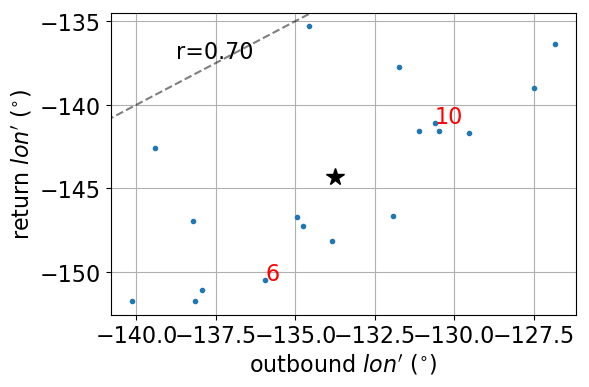

In [217]:
plot_coherence(df, varname="lon_p", label='$lon\'$', units="$^{\circ}$", pmeans=True)

In [198]:
df1 = df.drop(['upper_quartile', 'lower_quartile', 'mean'], axis=0)

prcp_out = np.array(df1['out_mean_prec'].values.astype(float))
prcp_ret = np.array(df1['ret_mean_prec'].values.astype(float))
index = np.logical_and(np.logical_and(~np.isnan(prcp_out), ~np.isnan(prcp_ret)),  prcp_ret < 0.25)
# index = np.logical_and(~np.isnan(prcp_out), ~np.isnan(prcp_ret))
lr = stats.linregress(prcp_out[index], prcp_ret[index])
print(lr)

LinregressResult(slope=0.11466529541124168, intercept=0.04762047755873742, rvalue=0.3677422989988275, pvalue=0.21638088120226642, stderr=0.08742613272139246)


4 ret_insitu: nan,  ret_goes: 13.115081229108371
15 ret_insitu: nan,  ret_goes: 16.143396676887537


LinregressResult(slope=0.5129231620473244, intercept=29.60066744507834, rvalue=0.37183987485096404, pvalue=0.030357304031777232, stderr=0.22636446664485912)

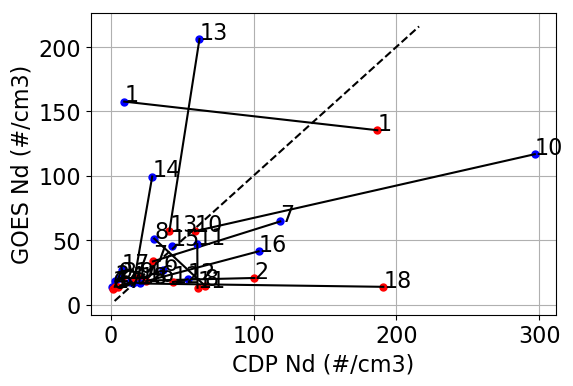

In [224]:
#aircraft vs GOES Nd
goes_nd = []
cdp_nd = []

goes_nd_all = {i: [] for i in [10, 25, 40, 50, 60, 75, 90]}
fig, ax = plt.subplots()
for key, case in combined_cases.items():
        
    out_nd_insitu = np.nanmedian(case.ALC.outbound_Flight_Piece.get_variable_by_leg(
    varname='CONCD_LWOI', legname='p', cloud_only=True).values)
    ret_nd_insitu = np.nanmedian(case.ALC.return_Flight_Piece.get_variable_by_leg(
    varname='CONCD_LWOI', legname='p', cloud_only=True).values)
    for k, v in goes_nd_all.items():
        out_nd_goes = np.nanpercentile(case.ALC.outbound_Flight_Piece.GOES_data['2deg'].Nd, k)
        ret_nd_goes =np.nanpercentile(case.ALC.return_Flight_Piece.GOES_data['2deg'].Nd, k)
        v.append(out_nd_goes)
        v.append(ret_nd_goes)

    
    out_nd_goes = np.nanpercentile(case.ALC.outbound_Flight_Piece.GOES_data['2deg'].Nd, 75)
    ret_nd_goes =np.nanpercentile(case.ALC.return_Flight_Piece.GOES_data['2deg'].Nd, 75)
    goes_nd.append(out_nd_goes)
    cdp_nd.append(out_nd_insitu)
    goes_nd.append(ret_nd_goes)
    cdp_nd.append(ret_nd_insitu)
    if not np.isnan(out_nd_insitu) or np.isnan(out_nd_goes):
        ax.plot(out_nd_insitu, out_nd_goes, 'b', marker='.', ms=10)
        plt.annotate(str(key), xy=(out_nd_insitu, out_nd_goes))
    else:
        print("{} out_insitu: {},  out_goes: {}".format(key, out_nd_insitu, out_nd_goes))
    if not np.isnan(ret_nd_insitu) or np.isnan(ret_nd_goes):
        ax.plot(ret_nd_insitu, ret_nd_goes, 'r', marker='.', ms=10)
        plt.annotate(str(key), xy=(ret_nd_insitu, ret_nd_goes))
    else:
        print("{} ret_insitu: {},  ret_goes: {}".format(key, ret_nd_insitu, ret_nd_goes))
    ax.plot([out_nd_insitu, ret_nd_insitu], [out_nd_goes, ret_nd_goes], 'k')
plt.plot([max([ax.get_ylim()[0], ax.get_xlim()[0]]), min([ax.get_ylim()[1], ax.get_xlim()[1]])],
         [max([ax.get_ylim()[0], ax.get_xlim()[0]]), min([ax.get_ylim()[1], ax.get_xlim()[1]])], 'k', ls='--')
ax.grid(True, which='major')
ax.grid(True, which='minor', ls='--')
ax.set_ylabel('GOES Nd (#/cm3)')
ax.set_xlabel('CDP Nd (#/cm3)');
# ax.set_yscale('log')
# ax.set_xscale('log')
idx = np.logical_and(~np.isnan(goes_nd), ~np.isnan(cdp_nd))
stats.linregress(np.array(goes_nd)[idx], np.array(cdp_nd)[idx])

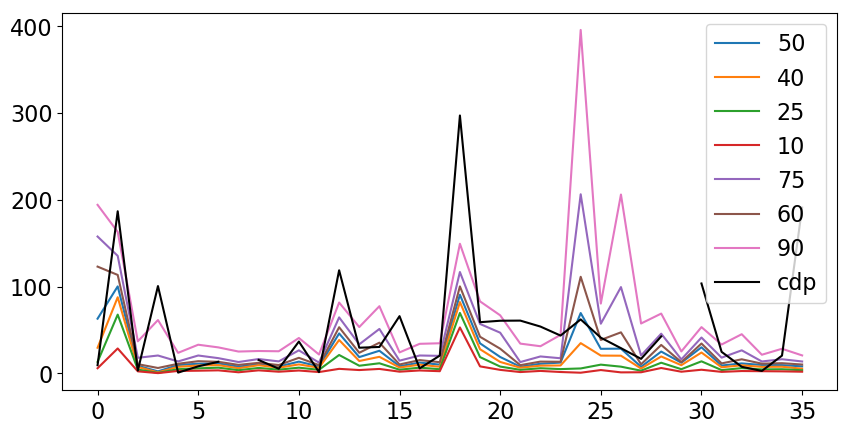

In [144]:
fig, ax = plt.subplots(figsize=(10,5))
for k, goes in goes_nd_all.items():
    ax.plot(goes, label=k)
ax.plot(cdp_nd, "k", label="cdp")
plt.legend()

In [149]:
cdp  = np.array(cdp_nd)
for k, goes in goes_nd_all.items():
    idx = np.logical_and(~np.isnan(goes), ~np.isnan(cdp))
    lr = stats.linregress(np.array(goes)[idx], np.array(cdp)[idx])
#     print(lr)
    bias = goes-cdp
    print("{}th pctile from goes: mean bias: {:0.0f}".format(k, np.nanmean(bias)))

50th pctile from goes: mean bias: -29
40th pctile from goes: mean bias: -35
25th pctile from goes: mean bias: -41
10th pctile from goes: mean bias: -47
75th pctile from goes: mean bias: -8
60th pctile from goes: mean bias: -22
90th pctile from goes: mean bias: 18


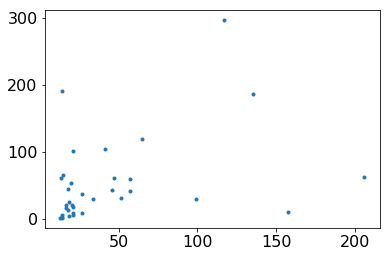

In [14]:
plt.plot(goes_nd, cdp_nd, '.')

In [232]:
all_aircraft_nd = np.hstack([df1['out_zi'].values,df1['ret_zi'].values]).astype(float)
all_goes_nd = goes_nd_all[75]
all_ERA_zi = np.hstack([df1['out_zi_traj'].values,df1['ret_zi_traj'].values]).astype(float)

all_CF = np.hstack([df1['out_GOES_CF'].values,df1['ret_GOES_CF'].values]).astype(float)

-0.49738746807696355

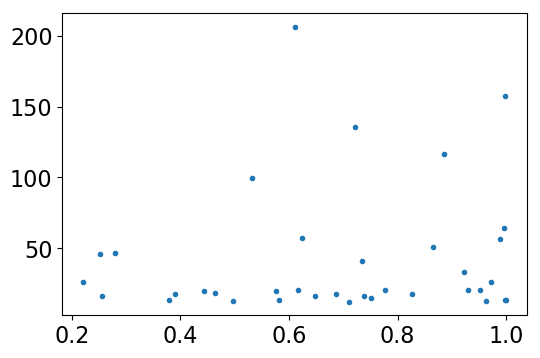

In [235]:
plt.plot(all_CF, all_goes_nd, '.')
utils.nan_correlate(all_CF, all_aircraft_nd)

In [143]:
all_aircraft_zi = np.hstack([df['out_zi'].values,df['ret_zi'].values])
all_ERA_zi = np.hstack([df['out_zi_traj'].values,df['ret_zi_traj'].values])

np.mean(all_aircraft_zi - all_ERA_zi)


# plt.plot(all_aircraft_zi, all_ERA_zi, '.')
# plt.plot([500,2500], [500, 2500])
# plt.ylabel('ERA')
# plt.xlabel('aircraft')

544.8155656106495

0.3667020992231311

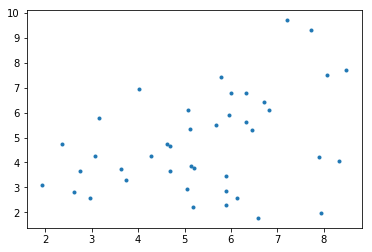

In [75]:
all_eis = np.hstack([df['out_EIS'].values,df['ret_EIS'].values]).astype('float')
all_delta_t = np.hstack([df['out_delta_T'].values,df['ret_delta_T'].values]).astype('float')
plt.plot(all_eis, all_delta_t, '.')
utils.nan_correlate(all_eis, all_delta_t)

In [89]:
x.columns

,out_time,ret_time,out_GOES_CF,ret_GOES_CF,diff_GOES_CF,out_EIS,ret_EIS,diff_EIS,out_LTS,ret_LTS,...,out_zi_traj,ret_zi_traj,diff_zi_traj,subs,entr,entr_TLC,dzidt_ALC,subs_700,shf,lhf
1,1.436290e+18,1.436474e+18,0.997243,0.886065,-0.111178,7.950623,7.720453,-0.230170,20.691885,20.362317,...,522.465357,572.874310,50.408953,-1.439416,1.629577,1.712294,0.190161,-6.874107,7.965453,84.250790
2,1.436293e+18,1.436468e+18,0.721257,0.989011,0.267754,6.713380,5.083241,-1.630139,20.265573,19.001996,...,540.997860,523.542596,-17.455264,-0.900170,0.937143,0.800275,0.036974,-5.128138,6.889760,81.486198
3,1.436719e+18,1.436907e+18,0.687373,0.280262,-0.407111,6.581055,6.123509,-0.457545,19.320410,19.164546,...,829.288300,744.413655,-84.874645,0.875046,-1.097964,-1.326718,-0.222918,-3.103780,7.625598,78.092379
4,1.436725e+18,1.436899e+18,0.615779,0.496688,-0.119091,5.892799,5.061400,-0.831400,18.867991,18.746289,...,976.930126,1207.072358,230.142232,1.728390,2.633783,-0.410603,4.362173,-3.087751,8.791246,108.660820
5,1.437150e+18,1.437337e+18,0.998279,0.443976,-0.554303,8.333402,5.901349,-2.432053,22.461205,18.465128,...,553.650834,818.679906,265.029073,0.059897,4.006400,1.359283,4.066297,-5.066880,8.206925,98.006294
6,1.437155e+18,1.437329e+18,0.951868,0.390778,-0.561090,5.677186,2.970348,-2.706838,19.910636,16.016624,...,572.894292,1353.211350,780.317058,0.626923,9.099060,3.860159,9.725984,-3.063461,9.868758,125.167630
7,1.437581e+18,1.437772e+18,0.826059,0.611100,-0.214959,7.892780,5.145826,-2.746954,19.369048,17.173609,...,589.852746,1183.850533,593.997787,-3.026548,7.715398,6.145711,4.688850,-5.088575,14.062711,121.154073
8,1.437585e+18,1.437765e+18,0.962015,0.623803,-0.338212,7.214528,3.745021,-3.469507,18.050135,16.618703,...,985.383095,1471.638831,486.255737,-3.602690,5.634833,6.303630,2.032143,-3.017578,16.166114,146.198049
9,1.437590e+18,1.437760e+18,0.738201,0.532052,-0.206149,6.318040,4.687971,-1.630069,18.252745,17.357046,...,1093.782683,1457.174494,363.391811,-1.412358,0.750265,3.544789,-0.662093,-2.413189,13.933679,150.295335
10,1.438015e+18,1.438203e+18,1.000000,0.775851,-0.224149,8.488096,3.627012,-4.861084,21.672540,16.431177,...,555.362936,1117.698308,562.335372,-2.740049,4.973426,5.731386,2.233377,-3.593582,10.213691,105.334155


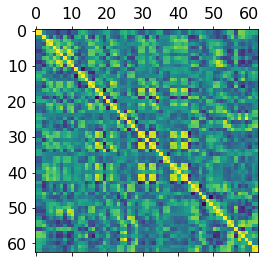

In [34]:
x = df.drop(['out_flight', 'out_seqs', 'ret_flight', 'ret_seqs', 'trajs'], axis=1).astype(float)
x = x.drop(['mean', 'upper_quartile', 'lower_quartile'], axis=0)
plt.matshow(x.corr())

masked = x.corr()
masked[np.abs(x.corr())<0.7] = 0
# plt.matshow(np.abs(x.corr())>0.8)
# plt.matshow(masked)

In [36]:
print("CF goes from {:0.3f} to {:0.3f}".format(np.nanmean(x['out_GOES_CF']), np.nanmean(x['ret_GOES_CF'])))


for i in x.columns:
    if i[:3] == 'out' and 'time' not in i:
        ret = 'ret'+ i[3:]
        diff = 'diff' + i[3:]
        mean = np.nanmean(x[diff])
        median = np.nanmedian(x[diff])
        dirn = 'increase' if mean>0 else 'decrease'
        agree = sum(np.sign(x[diff]) == np.sign(mean))
        median_agree = sum(np.sign(x[diff]) == np.sign(median))
        num = sum(~np.isnan(x[diff]))        
        print("for {}, mean change is {:0.3f}, and {}/{} agree".format(i[4:], mean, agree, num))
#         print("for {}, median change is {:0.3f}, and {}/{} agree".format(i[4:], median, median_agree, num))
#         corr = x.corr()[i][ret]
#         print("Lag coherence of {}: {:0.2f}".format(i[4:], corr))

CF goes from 0.846 to 0.531
for GOES_CF, mean change is -0.314, and 16/18 agree
for EIS, mean change is -2.185, and 18/18 agree
for LTS, mean change is -2.189, and 18/18 agree
for delta_q, mean change is -0.938, and 13/17 agree
for delta_T, mean change is -0.876, and 11/17 agree
for CDP_Nd, mean change is -14.866, and 5/14 agree
for CDP_Nd_p, mean change is 0.181, and 7/16 agree
for zi, mean change is 569.993, and 14/18 agree
for alpha_dec, mean change is 0.131, and 15/17 agree
for UHSAS_Na, mean change is -10.741, and 10/17 agree
for UHSAS_Na_cld, mean change is -7.368, and 7/13 agree
for mean_prec, mean change is -0.048, and 12/15 agree
for O3, mean change is 0.931, and 14/18 agree
for CO, mean change is -3.256, and 12/18 agree
for SST, mean change is 3.489, and 18/18 agree
for FT_RH, mean change is -9.780, and 15/18 agree
for FT_theta, mean change is 1.075, and 15/18 agree
for zi_traj, mean change is 369.015, and 15/18 agree


In [136]:
print(np.nanmean(df['entr']*1000))
print(np.nanmean(df['entr_TLC']*1000))
df['entr_TLC']*1000

4.766537314699711
3.6610180052176795


1      1.71229
2     0.800275
3     -1.32672
4    -0.410603
5      1.35928
6      3.86016
7      6.14571
8      6.30363
9      3.54479
10     5.73139
11     7.77504
12     1.57597
13     3.01934
14      6.3467
15     6.23533
16      4.1638
17      6.7553
18     2.30663
Name: entr_TLC, dtype: object

In [60]:
x.corr()['diff_delta_T'][10:]

diff_LTS             0.461019
out_delta_q          0.213245
ret_delta_q         -0.418639
diff_delta_q        -0.320647
out_delta_T         -0.515449
ret_delta_T          0.822158
diff_delta_T         1.000000
out_CDP_Nd           0.092852
ret_CDP_Nd           0.225770
diff_CDP_Nd          0.319538
out_CDP_Nd_p        -0.235080
ret_CDP_Nd_p         0.560855
diff_CDP_Nd_p        0.597920
out_zi               0.175857
ret_zi               0.062569
diff_zi              0.054944
out_alpha_dec        0.149064
ret_alpha_dec       -0.070166
diff_alpha_dec      -0.052020
out_UHSAS_Na         0.073523
ret_UHSAS_Na         0.295288
diff_UHSAS_Na        0.455596
out_UHSAS_Na_cld     0.105922
ret_UHSAS_Na_cld     0.275779
diff_UHSAS_Na_cld    0.450456
out_mean_prec       -0.015788
ret_mean_prec        0.487165
diff_mean_prec       0.445316
out_O3              -0.004925
ret_O3               0.024490
diff_O3              0.141083
out_CO               0.085449
ret_CO               0.178552
diff_CO   

In [117]:
x.corr()

,out_GOES_CF,ret_GOES_CF,diff_GOES_CF,out_EIS,ret_EIS,diff_EIS,out_LTS,ret_LTS,diff_LTS,out_CDP_Nd,...,diff_O3,out_CO,ret_CO,diff_CO,out_SST,ret_SST,diff_SST,out_FT_RH,ret_FT_RH,diff_FT_RH
out_GOES_CF,1.000000,0.175418,-0.433190,0.288630,-0.213415,-0.519968,0.423221,-0.350910,-0.650877,0.350844,...,-0.248412,0.444993,0.275858,-0.577842,-0.643116,-0.445340,0.544463,0.316488,0.052029,-0.259446
ret_GOES_CF,0.175418,1.000000,0.811338,0.509347,0.436120,0.031248,0.516067,0.418520,-0.043440,0.432329,...,0.720388,0.600742,0.636890,-0.333531,-0.262179,-0.326375,0.097542,-0.176881,0.114035,0.208484
diff_GOES_CF,-0.433190,0.811338,1.000000,0.294923,0.525990,0.337357,0.221156,0.591519,0.346711,0.180541,...,0.778185,0.285748,0.419271,0.037767,0.141849,-0.034360,-0.233995,-0.349860,0.073505,0.344922
out_EIS,0.288630,0.509347,0.294923,1.000000,0.567523,-0.275709,0.707290,0.378430,-0.232525,0.623049,...,0.616067,0.508221,0.595855,-0.185833,-0.507098,-0.374656,0.409116,-0.435849,-0.055378,0.364512
ret_EIS,-0.213415,0.436120,0.525990,0.567523,1.000000,0.634974,0.426632,0.931870,0.483390,0.377513,...,0.571828,0.385404,0.411626,-0.208859,-0.104235,-0.179301,-0.003782,-0.413221,-0.311173,0.230845
diff_EIS,-0.519968,0.031248,0.337357,-0.275709,0.634974,1.000000,-0.165552,0.732856,0.782512,-0.124181,...,0.058174,-0.026903,-0.078516,-0.069473,0.354104,0.142202,-0.388278,-0.073476,-0.311324,-0.072508
out_LTS,0.423221,0.516067,0.221156,0.707290,0.426632,-0.165552,1.000000,0.302381,-0.534976,0.309726,...,0.531342,0.322796,0.327475,-0.204110,-0.530026,-0.510234,0.325691,-0.040054,0.077259,0.070027
ret_LTS,-0.350910,0.418520,0.591519,0.378430,0.931870,0.732856,0.302381,1.000000,0.643550,0.180840,...,0.466607,0.282321,0.346188,-0.077591,0.184284,0.059791,-0.214281,-0.471840,-0.133994,0.361767
diff_LTS,-0.650877,-0.043440,0.346711,-0.232525,0.483390,0.782512,-0.534976,0.643550,1.000000,-0.074867,...,-0.051477,-0.008966,0.043887,0.095126,0.588950,0.462712,-0.451458,-0.386056,-0.180806,0.264425
out_CDP_Nd,0.350844,0.432329,0.180541,0.623049,0.377513,-0.124181,0.309726,0.180840,-0.074867,1.000000,...,0.234250,0.870198,0.796014,-0.690061,-0.383827,-0.451123,0.163848,-0.299943,0.065605,0.311400


In [171]:
for i in x.corr().columns:
    if i[:3] == 'out':
        ret = 'ret'+ i[3:]
        corr = x.corr()[i][ret]
        print("Lag coherence of {}: {:0.2f}".format(i[4:], corr))

Lag coherence of GOES_CF: 0.18
Lag coherence of EIS: 0.58
Lag coherence of LTS: 0.31
Lag coherence of CDP_Nd: 0.50
Lag coherence of CDP_Nd_p: -0.07
Lag coherence of zi: 0.05
Lag coherence of alpha_dec: 0.46
Lag coherence of UHSAS_Na: 0.86
Lag coherence of mean_prec: -0.01
Lag coherence of O3: 0.82
Lag coherence of CO: 0.93


In [156]:
self, seq = combined_cases[10].ALC.outbound_Flight_Piece, 'A'  # works well
self, seq = combined_cases[10].ALC.return_Flight_Piece, 'D' # miss top of inv
self, seq = combined_cases[10].ALC.return_Flight_Piece, 'E' # theta OK, q bad
self, seq = combined_cases[12].ALC.outbound_Flight_Piece, 'D' # don't go deep enough
self, seq = combined_cases[13].ALC.outbound_Flight_Piece, 'A' # does great
self, seq = combined_cases[6].ALC.outbound_Flight_Piece, 'B' # does great

In [157]:
d = self.flight_data.where(
        np.logical_and(self.flight_data.leg=='d', self.flight_data.sequence==seq), drop=True)
var_list = ['GGLAT', 'GGLON', 'GGALT', 'RHUM', 'ATX', 'MR', 'THETAE', 'THETA', 'PSXC', 'DPXC', 'PLWCC']    


sounding_dict = {}
sounding_dict['TIME'] = d.time.values
for i in var_list:
    sounding_dict[i] = d[i].values
if 'ATX' in var_list:
    sounding_dict['ATX'] = sounding_dict['ATX'] + 273.15


sounding_dict['DENS'] = mu.density_from_p_Tv(d['PSXC'].values*100, d['TVIR'].values+273.15)  
sounding_dict['QL'] = d['PLWCC'].values/sounding_dict['DENS']
sounding_dict['THETAL'] = mu.get_liquid_water_theta(
    sounding_dict['ATX'], sounding_dict['THETA'], sounding_dict['QL'])
sounding_dict['QV'] = d['MR'].values/(1+d['MR'].values/1000)

In [186]:
    usetheta=False
    from met_utils import heffter_pblht_1D
    z = sounding_dict['GGALT']
    theta = sounding_dict['THETA']
    theta_e = sounding_dict['THETAE']
    qv = sounding_dict['QV']
    t = sounding_dict['ATX']

    if not usetheta:
        theta_l = sounding_dict['THETAL']
        ql = sounding_dict['QL']
        qt = qv + ql
    else:
        theta_l = sounding_dict['THETA']
        qt = qv
    if np.all(np.isnan(ql)):
        qt = qv


    zi = heffter_pblht_1D(z, theta)


    upper_25 = zi['z_bot'] - (zi['z_bot'] - min(z))/4.
    u_i = np.logical_and(z > upper_25, z < zi['z_bot'])
    lower_25 = min(z) + (zi['z_bot'] - min(z))/4.
    l_i = np.logical_and(z < lower_25, z > min(z))

    ft_base = zi['z_bot']+500
    ft_top = ft_base + 500
    l_ft = np.logical_and(z < ft_top, z > ft_base)

    #     mbl = z<zi['z_bot']
    #     print(np.nansum(ql[mbl])/np.nansum(qv[mbl]))

    #     if zi['z_bot'] - min(z) < 300 or np.sum(l_ft) == 0:
    #         return {"d_qt": np.nan, "d_theta_e": np.nan, "d_theta_l": np.nan,
    #                 "alpha_thetal": np.nan, "alpha_qt":np.nan, "alpha_thetae": np.nan,
    #                 "d_q_inv": np.nan, "d_t_inv": np.nan}
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        theta_e_sml = np.nanmean(theta_e[l_i])
        theta_e_bzi = np.nanmean(theta_e[u_i])
        theta_e_uzi = np.nanmean(theta_e[l_ft])

        theta_l_sml = np.nanmean(theta_l[l_i])
        theta_l_bzi = np.nanmean(theta_l[u_i])
        theta_l_uzi = np.nanmean(theta_l[l_ft])

        qt_sml = np.nanmean(qt[l_i])
        qt_bzi = np.nanmean(qt[u_i])
        qt_uzi = np.nanmean(qt[l_ft])

    d_theta_e = theta_e_bzi - theta_e_sml
    d_theta_l = theta_l_bzi - theta_l_sml
    d_qt = qt_bzi - qt_sml

    alpha_thetal = (theta_l_bzi - theta_l_sml)/(theta_l_uzi - theta_l_sml)
    alpha_qt = (qt_bzi - qt_sml)/(qt_uzi - qt_sml)
    alpha_thetae = (theta_e_bzi - theta_e_sml)/(theta_e_uzi - theta_e_sml)

    # getting jumps across the inversion
    i_below_inv = np.logical_and(z > zi['z_bot']-50, z < zi['z_bot']+50)
    i_above_inv = np.logical_and(z > zi['z_top'], z < zi['z_top']+100)



    q_below_inv = np.nanmax(qt[i_below_inv])
    i_q_below_inv = np.nanargmin(qt[i_below_inv])
    z_q__below_inv = z[i_q_below_inv]
    q_above_inv = np.nanmin(qt[i_above_inv])
    i_q_above_inv = np.nanargmax(qt[i_above_inv])
    z_q_above_inv = z[i_q_above_inv]
    d_q_inv = q_above_inv - q_below_inv

    t_below_inv = np.nanmin(theta[i_below_inv])
    i_t_below_inv = np.nanargmin(theta[i_below_inv])
    z_t_below_inv = z[i_t_below_inv]
    t_above_inv = np.nanmax(theta[i_above_inv])
    i_t_above_inv = np.nanargmax(theta[i_above_inv])
    z_t_above_inv = z[i_t_above_inv]

    #     theta_below_inv = np.nanmean(theta_e_bzi)
    #     theta_above_inv = np.nanmean(theta_e_uzi) 
    d_t_inv = t_above_inv - t_below_inv

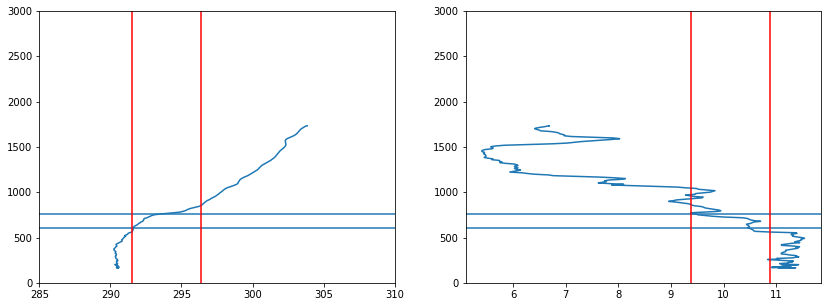

In [159]:
def make_delta_plots()


fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(14,5))


ax1.plot(theta, z)
ax1.set_ylim(0,3000)
ax1.set_xlim(285, 310)
ax1.axhline(zi['z_bot'], label='inv base')
ax1.axhline(zi['z_top'], label='inv top')

ax1.axvline(t_below_inv, label='t_below_inv', c='r')
ax1.axvline(t_above_inv, label='t_above_inv', c='r')



ax2.plot(qt, z)
ax2.set_ylim(0,3000)
ax2.axhline(zi['z_bot'], label='inv base')
ax2.axhline(zi['z_top'], label='inv top')

ax2.axvline(q_below_inv, label='q_below_inv', c='r')
ax2.axvline(q_above_inv, label='q_above_inv', c='r')

0.23716603420441035


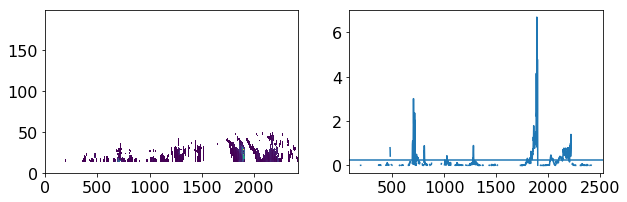

In [208]:
self = combined_cases[6].ALC.outbound_Flight_Piece
legname = 'b'
good_index = self.precip_data['leg'] == legname
prec = self.precip_data['lwf'][good_index]*3.6
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(10,3))
ax1.pcolormesh(prec.T)
pmax = prec.max(dim='height', skipna=True)   
ax2.plot(pmax)
ax2.axhline(np.nanmean(pmax))
print(np.nanmean(pmax))

0.1628469766821342


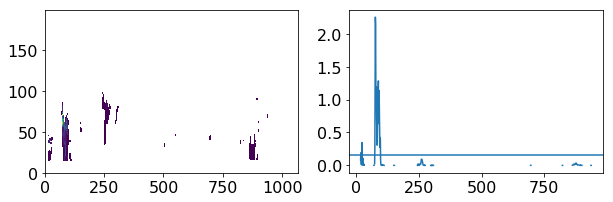

In [207]:
self = combined_cases[6].ALC.return_Flight_Piece
legname = 'b'
good_index = self.precip_data['leg'] == legname
prec = self.precip_data['lwf'][good_index]*3.6
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(10,3))
ax1.pcolormesh(prec.T)
pmax = prec.max(dim='height', skipna=True)   
ax2.plot(pmax)
ax2.axhline(np.nanmean(pmax))
print(np.nanmean(pmax))